# Brain Age Analysis: RPL Data
##### Date: August 20, 2024
##### **Student Name**: Jan Göbel
##### **University**: University of Tübingen
##### **Course**: Lab Project SoSe24-WiSe24¶

### Overview
This notebook analyzes the relationship between unexpected repeated pregnancy loss
and predicted brain age in mothers.

### 1. Imports and Setup
Here I imported the necessary libraries and defined paths.

In [19]:
# Import necessary libraries
import os
import nibabel as nib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.formula.api import ols
from scipy.stats import shapiro
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression

In [5]:
# Define path to participant data
LABELS_FILE = '...' # include your path here

# Load the labels
labels = pd.read_csv(LABELS_FILE, sep=',')

In [4]:
# Use LaTeX font settings in Matplotlib plots
plt.rcParams.update({
    "text.usetex": True,  # Use LaTeX for text rendering
    "font.family": "serif",  # Use LaTeX's default font family
    "font.serif": ["Computer Modern Roman"],  # Set LaTeX font to Computer Modern
    "font.size": 16,  # Set the base font size
    "axes.labelsize": 18,  # Font size for the axis labels
    "axes.titlesize": 20,  # Font size for the plot titles
    "legend.fontsize": 14,  # Font size for the legend
    "xtick.labelsize": 14,  # Font size for x-axis tick labels
    "ytick.labelsize": 14,  # Font size for y-axis tick labels
})

### 2. Data Loading and Inspection
Load the dataset and perform initial inspection on the data.

In [6]:
labels.head(5)

,table1 codes,bids code,age,gender,group
0,CTRL02,sub-01,26,F,control
1,CTRL03,sub-02,26,F,control
2,CTRL04,sub-03,28,F,control
3,CTRL05,sub-04,28,F,control
4,CTRL07,sub-05,31,F,control


In [7]:
labels[labels['group'] == 'control']['age'].describe()

count    33.000000
mean     34.545455
std       4.437700
min      26.000000
25%      32.000000
50%      35.000000
75%      37.000000
max      47.000000
Name: age, dtype: float64

In [10]:
# Load the prediction file into a DataFrame
csv_file_path = '...' # include your path here

# Load predictions from CSV
predictions = pd.read_csv(csv_file_path)

# Merge predictions with true labels
merged_df = pd.merge(predictions, labels[['bids code', 'age', 'group']], left_on='id', right_on='bids code', how='left')

# Drop unnecessary columns
merged_df = merged_df.drop(columns=['bids code'])

# Rename columns for clarity
merged_df = merged_df.rename(columns={'age': 'true_age', 'group': 'true_group'})

# Display the merged DataFrame
merged_df.head(5)

,id,prediction,true_age,true_group
0,sub-01,29.518500,26,control
1,sub-02,23.592913,26,control
2,sub-03,27.196629,28,control
3,sub-04,21.747510,28,control
4,sub-05,35.977080,31,control


### 3. Statistical Analysis & Visualizations
In this section, I performed statistical tests like the Shapiro-Wilk test and t-tests to compare the RPL and control groups.

In [11]:
# Shapiro-Wilk test for control group
stat, p_value = shapiro(merged_df[merged_df['true_group'] == 'control']['prediction'].dropna()) 

print(f'Statistic: {stat}, p-value: {p_value}')

Statistic: 0.9729458210469191, p-value: 0.6225048147952121


In [12]:
# Shapiro-Wilk test for RPL group
stat, p_value = shapiro(merged_df[merged_df['true_group'] == 'RPL']['prediction'].dropna())  

print(f'Statistic: {stat}, p-value: {p_value}')

Statistic: 0.9583216207957928, p-value: 0.3820607534028439


#### t-Test

In [13]:
# Calculate brain age difference (prediction - true_age)
merged_df['brain_age_diff'] = merged_df['prediction'] - merged_df['true_age']

# Separate groups for the t-test
group_control = merged_df[merged_df['true_group'] == 'control']['brain_age_diff']
group_treatment = merged_df[merged_df['true_group'] != 'control']['brain_age_diff']

In [14]:
# Perform an independent t-test
t_stat, p_value = stats.ttest_ind(group_control, group_treatment, equal_var=False)  # Welch's t-test
print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: 0.5406674074107514, P-value: 0.5912242204121998


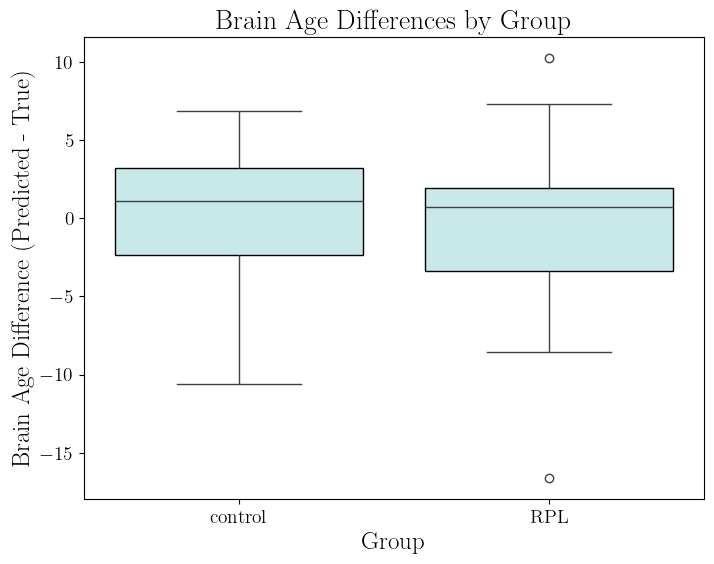

In [15]:
# Boxplot for Brain Age Differences by Group
plt.figure(figsize=(8, 6))
sns.boxplot(x='true_group', y='brain_age_diff', data=merged_df, 
            boxprops=dict(facecolor="#C9E8EA", edgecolor='black'))

# Customize plot labels and title
plt.title('Brain Age Differences by Group')
plt.xlabel('Group')
plt.ylabel('Brain Age Difference (Predicted - True)')

# Save and show the plot
plt.savefig("brain_age_diff_by_group.png", dpi=300)
plt.show()

### 4. Error Metrics and Model Performance
I calculated the Mean Absolute Error (MAE) and analyze the performance of the brain age prediction model.

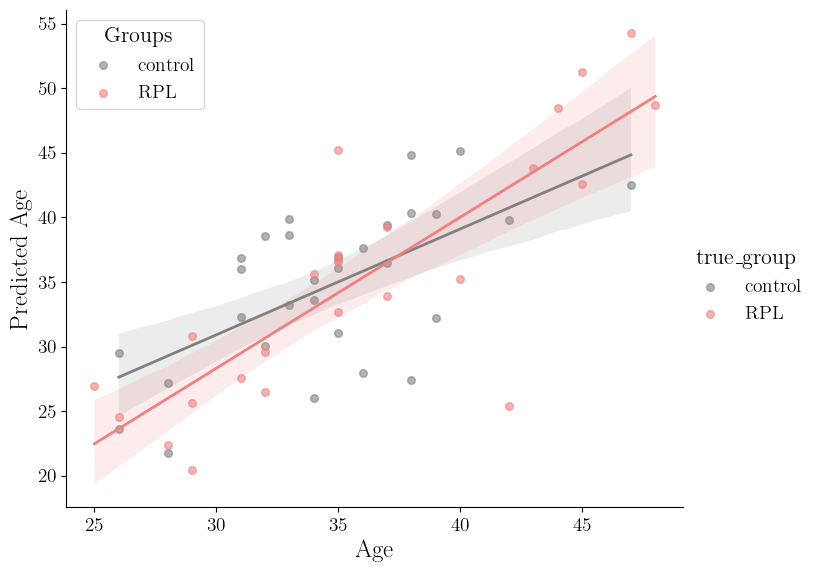

In [16]:
# Plot with seaborn's lmplot, which includes confidence bands
sns.lmplot(
    data=merged_df,
    x='true_age',
    y='prediction',
    hue='true_group',
    palette={'control': 'grey', 'RPL': 'lightcoral'},
    height=6,
    aspect=1.2,
    ci=95,
    markers=["o", "o"],
    scatter_kws={"s": 30, "alpha": 0.6},
    line_kws={"linewidth": 2}
)

# Customize plot labels and title
plt.xlabel('Age')
plt.ylabel('Predicted Age')

# Change the legend title
plt.legend(title='Groups')

# Save and show the plot
plt.savefig("brain_age_control_vs_rpl.png", dpi=300)
plt.show()

In [17]:
# Function to calculate MAE
def calculate_mae(group):
    return np.mean(np.abs(group['prediction'] - group['true_age']))

def permutation_test(group1, group2, n_permutations=10000):
    # Combine the data
    combined = pd.concat([group1, group2])
    
    # Calculate the observed difference in MAE
    observed_diff = calculate_mae(group1) - calculate_mae(group2)
    
    # Perform permutations
    permuted_diffs = []
    for _ in range(n_permutations):
        # Randomly shuffle the group labels
        permuted = combined.copy()
        permuted['true_group'] = np.random.permutation(permuted['true_group'])
        
        # Recalculate MAE for permuted groups
        permuted_group1 = permuted[permuted['true_group'] == 'control']
        permuted_group2 = permuted[permuted['true_group'] != 'control']
        
        permuted_diff = calculate_mae(permuted_group1) - calculate_mae(permuted_group2)
        permuted_diffs.append(permuted_diff)
    
    # Calculate p-value
    p_value = np.mean(np.abs(permuted_diffs) >= np.abs(observed_diff))
    
    return observed_diff, p_value

# Separate the groups
control_group = merged_df[merged_df['true_group'] == 'control']
non_control_group = merged_df[merged_df['true_group'] != 'control']

# Perform the permutation test
observed_diff, p_value = permutation_test(control_group, non_control_group)

# Calculate MAE for both groups
control_mae = calculate_mae(control_group)
non_control_mae = calculate_mae(non_control_group)

# Print results
print(f"Control Group MAE: {control_mae:.2f}")
print(f"Non-Control Group MAE: {non_control_mae:.2f}")
print(f"Observed difference in MAE: {observed_diff:.2f}")
print(f"P-value: {p_value:.4f}")

# Interpret the results
alpha = 0.05  # conventional significance level
if p_value < alpha:
    print(f"The difference in MAE between the two groups is statistically significant (p < {alpha}).")
else:
    print(f"There is no statistically significant difference in MAE between the two groups (p >= {alpha}).")

# Additional: Effect size (Cohen's d)
pooled_std = np.sqrt((control_group['prediction'].std()**2 + non_control_group['prediction'].std()**2) / 2)
cohens_d = np.abs(observed_diff) / pooled_std
print(f"Effect size (Cohen's d): {cohens_d:.2f}")

# Interpret effect size
if cohens_d < 0.2:
    print("The effect size is small.")
elif cohens_d < 0.5:
    print("The effect size is medium.")
else:
    print("The effect size is large.")

Control Group MAE: 3.84
Non-Control Group MAE: 4.09
Observed difference in MAE: -0.25
P-value: 0.7708
There is no statistically significant difference in MAE between the two groups (p >= 0.05).
Effect size (Cohen's d): 0.03
The effect size is small.


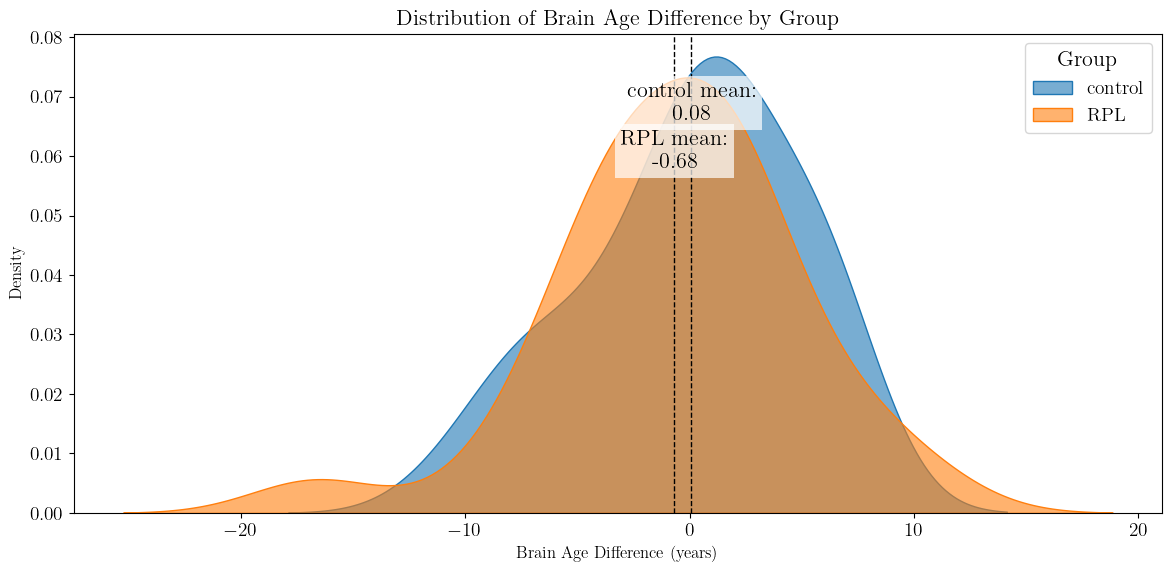

            count      mean       std        min       25%       50%  \
true_group                                                             
RPL          25.0 -0.682304  5.467052 -16.640900 -3.348840  0.708305   
control      30.0  0.075220  4.798471 -10.613714 -2.353178  1.124054   

                 75%        max  
true_group                       
RPL         1.949644  10.231606  
control     3.233098   6.842730  


In [25]:
# Set up the plot
plt.figure(figsize=(12, 6))

# Create the density plot
for group in merged_df['true_group'].unique():
    group_data = merged_df[merged_df['true_group'] == group]
    sns.kdeplot(data=group_data, x='brain_age_diff', fill=True, alpha=0.6, label=group)

# Customize the plot
plt.title('Distribution of Brain Age Difference by Group', fontsize=16)
plt.xlabel('Brain Age Difference (years)', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Add vertical lines and labels for mean MAE of each group
y_max = plt.gca().get_ylim()[1]
for i, group in enumerate(merged_df['true_group'].unique()):
    mean_mae = merged_df[merged_df['true_group'] == group]['brain_age_diff'].mean()
    plt.axvline(mean_mae, color='k', linestyle='dashed', linewidth=1)
    plt.text(mean_mae, y_max * (0.9 - i*0.1), f'{group} mean:\n{mean_mae:.2f}', 
             horizontalalignment='center', verticalalignment='top',
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Add legend
plt.legend(title='Group')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

# Print summary statistics
print(merged_df.groupby('true_group')['brain_age_diff'].describe())

In [20]:
# Create a binary variable for group: control = 0, RPL = 1
merged_df['group_binary'] = np.where(merged_df['true_group'] == 'control', 0, 1)

# Perform OLS regression with brain age difference as the dependent variable, and group + age as independent variables
model = ols('brain_age_diff ~ group_binary + true_age', data=merged_df).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         brain_age_diff   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.2039
Date:                Wed, 23 Oct 2024   Prob (F-statistic):              0.816
Time:                        12:55:02   Log-Likelihood:                -166.70
No. Observations:                  55   AIC:                             339.4
Df Residuals:                      52   BIC:                             345.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.3747      4.409     -0.312   